In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, matthews_corrcoef\
, precision_score, recall_score, f1_score
import time
import math
from collections import defaultdict

In [2]:
import os
import sys
new_path = "d:/Projects-my/ml/Ml-hse-final/ada-boost-implementations/code-python/"
sys.path.append(new_path)

from ada_boost_standard_v1 import AdaBoostStandardClassifier_v1;
#from ada_boost_standard_v2 import AdaBoostStandardClassifier_v2;
from ada_boost_linear_v1 import AdaBoostLinear_v1;
from generation_utils import make_classification_normal, make_separable_labels;

In [3]:
def compute_metrics(y_test, y_pred):
    print('Accuracy: {:.5f}'.format(accuracy_score(y_test, y_pred)))
    print('F-score: {:.5f}'.format(f1_score(y_test, y_pred)))
    print('Precision: {:.5f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.5f}'.format(recall_score(y_test, y_pred)))
    print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_test, y_pred)))
    print('MCC: {:.5f}'.format(matthews_corrcoef(y_test, y_pred)))

def compute_confusion_matrix(y_test, y_pred, labels=[1, -1]):
    compute_metrics(y_test, y_pred)
    return pd.DataFrame(
        confusion_matrix(y_test, y_pred, labels=labels),
        columns=['a(x) = '+str(labels[0]), 'a(x) = '+str(labels[1])],
        index=['y = '+str(labels[0]), 'y = '+str(labels[1])],
    ).T

def draw_data_by_coord01(x_data, y_data, v_normal):
    plt.scatter(x_data[:, 0], x_data[:, 1], marker="o", c=y_data, s=10, edgecolor="k")
    y2_coord = -2*v_normal[0]/(v_normal[1] + 1e-10)
    plt.plot([-2,2], [-y2_coord, y2_coord], color='r')
    plt.show()

In [4]:
def generate_data(n_samples=200, n_features=50,n_informative=20, n_redundant=20, rho=0.1):
    x_raw, _ = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative
                                   , n_redundant=n_redundant, random_state=0, n_clusters_per_class=5, shuffle=False)

    x_data, y_data, v_normal = make_separable_labels(x_raw, rho)
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test

In [11]:
def get_predicts(X_train, X_test, y_train, y_test):
    #Linear
    clfLinear = AdaBoostLinear_v1()
    result, message, _ = clfLinear.fit(X_train, y_train, allow_nonseparable=True)
    y_pred_linear = clfLinear.predict(X_test)
    #Ada-boost sklearn
    clfSkln = AdaBoostClassifier(n_estimators=150, random_state=0)
    clfSkln.fit(X_train, y_train)
    y_pred_sklearn = clfSkln.predict(X_test)
    #Ada-boost decision-stump
    clfStd = AdaBoostStandardClassifier_v1(n_estimators=150)
    clfStd.fit(X_train, y_train, trace=True)
    y_pred_stump = clfStd.predict(X_test)
    return y_pred_linear, y_pred_sklearn, y_pred_stump, 


In [6]:
#Linear
def get_predicts_linear_v1(X_train, X_test, y_train, y_test):
    clf = AdaBoostLinear_v1()
    result, message, _ = clf.fit(X_train, y_train, allow_nonseparable=True)
    separated = accuracy_score(y_train, clf.predict(X_train))
    y_pred = clf.predict(X_test)
    margin = clf.get_margin()
    return y_pred, margin, separated, clf
    
#Ada-boost sklearn
def get_predict_sklearn(X_train, X_test, y_train, y_test):
    clf = AdaBoostClassifier(n_estimators=150, random_state=0)
    clf.fit(X_train, y_train)
    separated = accuracy_score(y_train, clf.predict(X_train))
    y_pred = clf.predict(X_test)
    return y_pred, separated, clf

#Ada-boost decision-stump
def get_predict_stump_v1(X_train, X_test, y_train, y_test):
    clf = AdaBoostStandardClassifier_v1(n_estimators=150)
    clf.fit(X_train, y_train, trace=True)
    separated = accuracy_score(y_train, clf.predict(X_train))
    margin = clf.get_margin_l1(X_train)
    y_pred = clf.predict(X_test)
    return y_pred, margin, separated, clf


In [9]:
def get_metrics(X_train, X_test, y_train, y_test):
    metrics_linear={}
    metrics_sklearn={}
    metrics_stump={}
    #y_pred_linear, y_pred_sklearn, y_pred_stump = get_predicts(X_train, X_test, y_train, y_test)
    #Linear
    y_pred_linear, margin, separated, clf = get_predicts_linear_v1(X_train, X_test, y_train, y_test)
    metrics_linear['accuracy'] = accuracy_score(y_test, y_pred_linear)
    metrics_linear['precision'] = precision_score(y_test, y_pred_linear)
    metrics_linear['recall'] = recall_score(y_test, y_pred_linear)
    metrics_linear['margin'] = margin
    #Ada-boost sklearn
    y_pred_sklearn, separated, clf = get_predict_sklearn(X_train, X_test, y_train, y_test)
    metrics_sklearn['accuracy'] = accuracy_score(y_test, y_pred_sklearn)
    metrics_sklearn['precision'] = precision_score(y_test, y_pred_sklearn)
    metrics_sklearn['recall'] = recall_score(y_test, y_pred_sklearn)
    #Ada-boost decision-stump
    y_pred_stump, margin, separated, clf = get_predict_stump_v1(X_train, X_test, y_train, y_test)
    metrics_stump['accuracy'] = accuracy_score(y_test, y_pred_stump)
    metrics_stump['precision'] = precision_score(y_test, y_pred_stump)
    metrics_stump['recall'] = recall_score(y_test, y_pred_stump)
    metrics_stump['margin'] = margin
    return metrics_linear, metrics_sklearn, metrics_stump


#### Data generation

#### Varying the number of features

In [16]:
TESTS_COUNT=3

features_list=[25,50,75,100,125,150,175,200]#,225,250,275,300,325,350,375,400,425,450,475,500]

accuracy_linear=[]
accuracy_sklearn=[]
accuracy_stump=[]
margin_linear=[]
margin_stump=[]

for features in features_list:
    print("processing dataset with {} features".format(features))
    n_features, n_informative, n_redundant= features, features, 0 #int(features*0.4), int(features*0.4)
    buff_linear, buff_sklearn, buff_stump, buffm_linear, buffm_stump=[], [], [], [], []
    for _ in range(TESTS_COUNT):
        X_train, X_test, y_train, y_test = generate_data \
            (n_features=n_features, n_informative=n_informative, n_redundant=n_redundant)
        metrics_linear, metrics_sklearn, metrics_stump = get_metrics(X_train, X_test, y_train, y_test)
        buff_linear.append(metrics_linear['accuracy'])
        buff_sklearn.append(metrics_sklearn['accuracy'])
        buff_stump.append(metrics_stump['accuracy'])
        buffm_linear.append(metrics_linear['margin'])
        buffm_stump.append(metrics_stump['margin'])
        
    accuracy_linear.append(sum(buff_linear)/TESTS_COUNT)
    accuracy_sklearn.append(sum(buff_sklearn)/TESTS_COUNT)
    accuracy_stump.append(sum(buff_stump)/TESTS_COUNT)
    margin_linear.append(sum(buff_linear)/TESTS_COUNT)
    margin_stump.append(sum(buff_stump)/TESTS_COUNT)


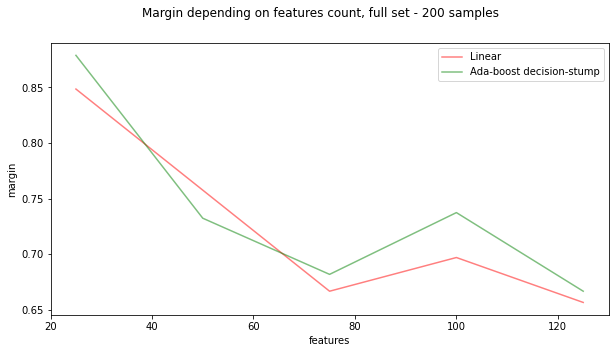

In [13]:
options = [
    ('r', 'Linear'),
    ('b', 'Ada-boost sklearn'),
    ('g', 'Ada-boost decision-stump')
]

plt.figure(figsize=(10, 5))
plt.xlabel('features')
plt.ylabel('margin')
plt.suptitle("Margin depending on features count, full set - 200 samples")

plt.plot(features_list, margin_linear, options[0][0], alpha=0.5, label=options[0][1])
#plt.plot(features_list, accuracy_sklearn, options[1][0], alpha=0.5, label= options[1][1])
plt.plot(features_list, margin_stump, options[2][0], alpha=0.5, label= options[2][1])
tmp = plt.legend(bbox_to_anchor=(1, 1))

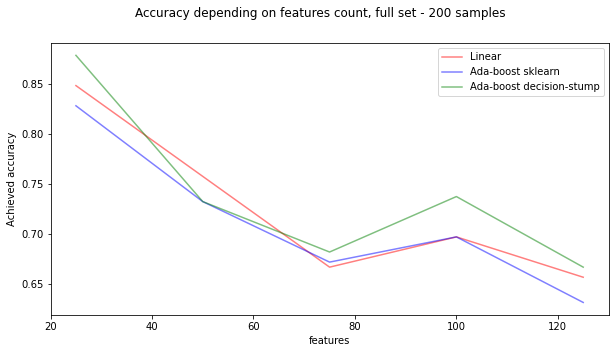

In [14]:
options = [
    ('r', 'Linear'),
    ('b', 'Ada-boost sklearn'),
    ('g', 'Ada-boost decision-stump')
]

plt.figure(figsize=(10, 5))
plt.xlabel('features')
plt.ylabel('Achieved accuracy')
plt.suptitle("Accuracy depending on features count, full set - 200 samples")

plt.plot(features_list, accuracy_linear, options[0][0], alpha=0.5, label=options[0][1])
plt.plot(features_list, accuracy_sklearn, options[1][0], alpha=0.5, label= options[1][1])
plt.plot(features_list, accuracy_stump, options[2][0], alpha=0.5, label= options[2][1])
tmp = plt.legend(bbox_to_anchor=(1, 1))

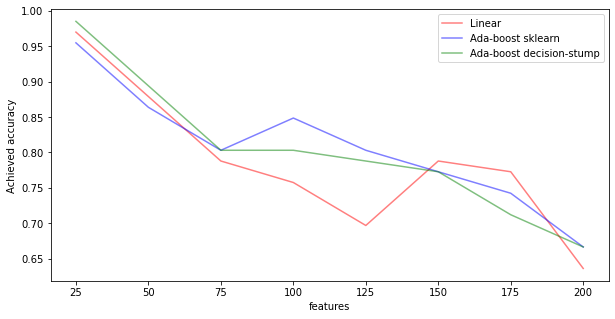

In [33]:
options = [
    ('r', 'Linear'),
    ('b', 'Ada-boost sklearn'),
    ('g', 'Ada-boost decision-stump')
]

plt.figure(figsize=(10, 5))
plt.xlabel('features')
plt.ylabel('Achieved accuracy')

plt.plot(features_list, accuracy_linear, options[0][0], alpha=0.5, label=options[0][1]) # + ':'
plt.plot(features_list, accuracy_sklearn, options[1][0], alpha=0.5, label= options[1][1]) # + ':'
plt.plot(features_list, accuracy_stump, options[2][0], alpha=0.5, label= options[2][1]) # + ':'
tmp = plt.legend(bbox_to_anchor=(1, 1))

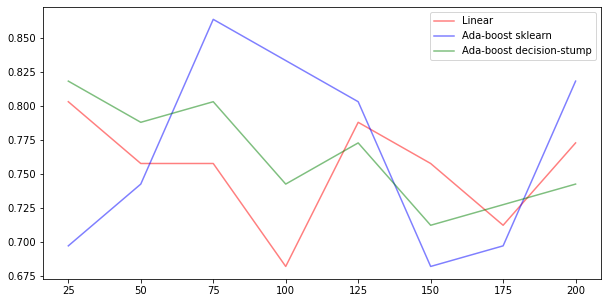

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(features_list, accuracy_linear, options[0][0], alpha=0.5, label=options[0][1]) # + ':'
plt.plot(features_list, accuracy_sklearn, options[1][0], alpha=0.5, label= options[1][1]) # + ':'
plt.plot(features_list, accuracy_stump, options[2][0], alpha=0.5, label= options[2][1]) # + ':'
dummy = plt.legend(bbox_to_anchor=(1, 1))

#### Varying the margin size

In [64]:
TESTS_COUNT=3
FEATURES=100

rho_list=[0,0.001,0.01,0.1,1,10]#,225,250,275,300,325,350,375,400,425,450,475,500]
accuracy_linear=[]
accuracy_sklearn=[]
accuracy_stump=[]

for v_rho in rho_list:
    print("processing dataset with {} margin size".format(v_rho))
    n_features, n_informative, n_redundant= FEATURES, int(FEATURES*0.4), int(FEATURES*0.4)
    buff_linear, buff_sklearn, buff_stump=[], [], []
    for _ in range(TESTS_COUNT):
        X_train, X_test, y_train, y_test = generate_data \
            (n_features=n_features, n_informative=n_informative, n_redundant=n_redundant, rho=v_rho)
        metrics_linear, metrics_sklearn, metrics_stump = get_metrics(X_train, X_test, y_train, y_test)
        buff_linear.append(metrics_linear['accuracy'])
        buff_sklearn.append(metrics_sklearn['accuracy'])
        buff_stump.append(metrics_stump['accuracy'])
        
    accuracy_linear.append(sum(buff_linear)/TESTS_COUNT)
    accuracy_sklearn.append(sum(buff_sklearn)/TESTS_COUNT)
    accuracy_stump.append(sum(buff_stump)/TESTS_COUNT)


processing dataset with 0 margin size
processing dataset with 0.001 margin size
processing dataset with 0.01 margin size
processing dataset with 0.1 margin size
processing dataset with 1 margin size
processing dataset with 10 margin size


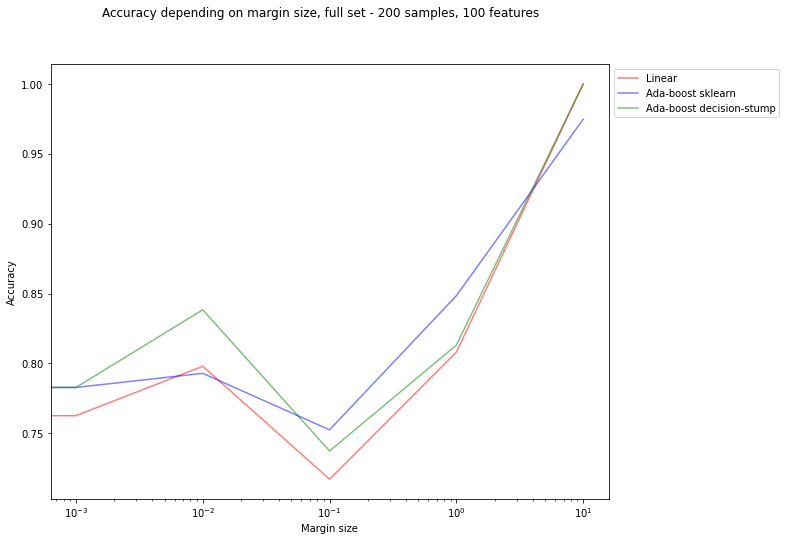

In [65]:
options = [
    ('r', 'Linear'),
    ('b', 'Ada-boost sklearn'),
    ('g', 'Ada-boost decision-stump')
]

plt.figure(figsize=(10, 8))
plt.xlabel('Margin size')
plt.ylabel('Accuracy')
plt.xscale("log")
plt.suptitle("Accuracy depending on margin size, full set - 200 samples, 100 features")

plt.plot(rho_list, accuracy_linear, options[0][0], alpha=0.5, label=options[0][1])
plt.plot(rho_list, accuracy_sklearn, options[1][0], alpha=0.5, label= options[1][1])
plt.plot(rho_list, accuracy_stump, options[2][0], alpha=0.5, label= options[2][1])
tmp = plt.legend(bbox_to_anchor=(1, 1))

In [58]:
FEATURES=100
TESTS_COUNT=3

informative_percent_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]#,275,300,325,350,375,400,425,450,475,500]
accuracy_linear=[]
accuracy_sklearn=[]
accuracy_stump=[]

for informative_percent in informative_percent_list:
    print("processing dataset with {} informative percent".format(informative_percent))
    n_features, n_informative, n_redundant= FEATURES, int(FEATURES*informative_percent), int(FEATURES*(0.9-informative_percent))
    buff_linear, buff_sklearn, buff_stump=[], [], []
    for _ in range(TESTS_COUNT):
        X_train, X_test, y_train, y_test = generate_data \
            (n_features=n_features, n_informative=n_informative, n_redundant=n_redundant)
        metrics_linear, metrics_sklearn, metrics_stump = get_metrics(X_train, X_test, y_train, y_test)
        buff_linear.append(metrics_linear['accuracy'])
        buff_sklearn.append(metrics_sklearn['accuracy'])
        buff_stump.append(metrics_stump['accuracy'])
        
    accuracy_linear.append(sum(buff_linear)/TESTS_COUNT)
    accuracy_sklearn.append(sum(buff_sklearn)/TESTS_COUNT)
    accuracy_stump.append(sum(buff_stump)/TESTS_COUNT)


processing dataset with 0.1 informative percent
processing dataset with 0.2 informative percent
processing dataset with 0.3 informative percent
processing dataset with 0.4 informative percent
processing dataset with 0.5 informative percent
processing dataset with 0.6 informative percent
processing dataset with 0.7 informative percent
processing dataset with 0.8 informative percent
processing dataset with 0.9 informative percent


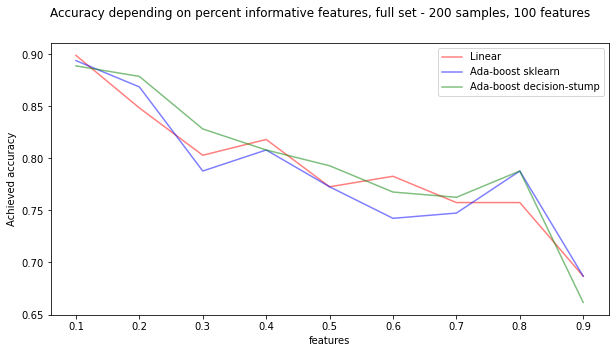

In [60]:
options = [
    ('r', 'Linear'),
    ('b', 'Ada-boost sklearn'),
    ('g', 'Ada-boost decision-stump')
]

plt.figure(figsize=(10, 5))
plt.xlabel('Informative features percent')
plt.ylabel('Achieved accuracy')
plt.suptitle("Accuracy depending on percent informative features, full set - 200 samples, 100 features")

plt.plot(informative_percent_list, accuracy_linear, options[0][0], alpha=0.5, label=options[0][1])
plt.plot(informative_percent_list, accuracy_sklearn, options[1][0], alpha=0.5, label= options[1][1])
plt.plot(informative_percent_list, accuracy_stump, options[2][0], alpha=0.5, label= options[2][1])
tmp = plt.legend(bbox_to_anchor=(1, 1))

In [66]:
FEATURES=100
TESTS_COUNT=3

informative_percent_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
accuracy_linear=[]
accuracy_sklearn=[]
accuracy_stump=[]

for informative_percent in informative_percent_list:
    print("processing dataset with {} informative percent".format(informative_percent))
    n_features, n_informative, n_redundant= FEATURES, int(FEATURES*informative_percent), int(FEATURES*(0.8-informative_percent))
    buff_linear, buff_sklearn, buff_stump=[], [], []
    for _ in range(TESTS_COUNT):
        X_train, X_test, y_train, y_test = generate_data \
            (n_features=n_features, n_informative=n_informative, n_redundant=n_redundant, rho=0.01)
        metrics_linear, metrics_sklearn, metrics_stump = get_metrics(X_train, X_test, y_train, y_test)
        buff_linear.append(metrics_linear['accuracy'])
        buff_sklearn.append(metrics_sklearn['accuracy'])
        buff_stump.append(metrics_stump['accuracy'])
        
    accuracy_linear.append(sum(buff_linear)/TESTS_COUNT)
    accuracy_sklearn.append(sum(buff_sklearn)/TESTS_COUNT)
    accuracy_stump.append(sum(buff_stump)/TESTS_COUNT)


processing dataset with 0.1 informative percent
processing dataset with 0.2 informative percent
processing dataset with 0.3 informative percent
processing dataset with 0.4 informative percent
processing dataset with 0.5 informative percent
processing dataset with 0.6 informative percent
processing dataset with 0.7 informative percent
processing dataset with 0.8 informative percent


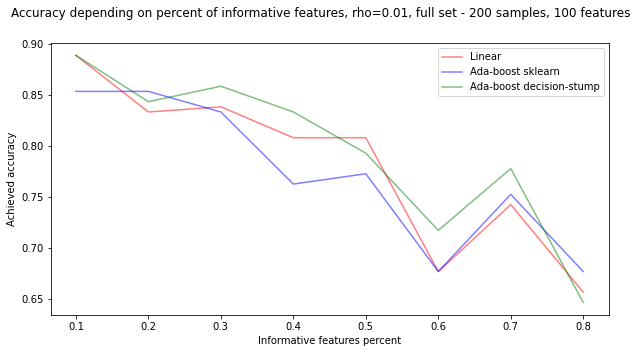

In [67]:
options = [
    ('r', 'Linear'),
    ('b', 'Ada-boost sklearn'),
    ('g', 'Ada-boost decision-stump')
]

plt.figure(figsize=(10, 5))
plt.xlabel('Informative features percent')
plt.ylabel('Achieved accuracy')
plt.suptitle("Accuracy depending on percent of informative features, rho=0.01, full set - 200 samples, 100 features")

plt.plot(informative_percent_list, accuracy_linear, options[0][0], alpha=0.5, label=options[0][1])
plt.plot(informative_percent_list, accuracy_sklearn, options[1][0], alpha=0.5, label= options[1][1])
plt.plot(informative_percent_list, accuracy_stump, options[2][0], alpha=0.5, label= options[2][1])
tmp = plt.legend(bbox_to_anchor=(1, 1))